# Scenario Analysis

In this jupyter notebook, the code can be found that was used to perform scenario analysis on the room for the river model used in EPA1361 Model Based Decision making.


In [2]:
#imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (Model, CategoricalParameter,ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, ema_logging, Constant, Policy, Scenario,
                           perform_experiments, SequentialEvaluator,Constraint)
from problem_formulation import get_model_for_problem_formulation

import dike_model_function 

from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress,GenerationalBorg)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import plotting, plotting_util, parcoords, feature_scoring, prim
from ema_workbench.analysis import dimensional_stacking

from mpl_toolkits.mplot3d import Axes3D 

import time
import copy

from ema_workbench.analysis.plotting_util import COLOR_LIST as colors
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

### Run Model 

In [3]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 


### Load results from previous executed model run

In [4]:
# Reading in experiments and outcomes from previously performed samples
df_experiments_s1000_p10 = pd.read_csv("output_data/df_experiments_s1000_p10.csv")
df_outcomes_s1000_p10 = pd.read_csv("output_datadf_outcomes_s1000_p10.csv")


In [4]:
print('Outcome keys', df_outcomes_s1000_p10.keys())
print('Experiment keys', df_experiments_s1000_p10.keys())

Outcome keys Index(['Unnamed: 0', 'A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths',
       'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs',
       'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage',
       'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
       'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')
Experiment keys Index(['Unnamed: 0', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate',
       'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax',
       'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail',
       'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0',
       'discount rate 1', 'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2',
       

# Gorssel

## Initial Feature Scoring

In [5]:
# Define uncertainty, outcome and lever columns
uncertainties_columns = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2'] 
outcomes_of_interest = ['A.4_Expected Annual Damage', 'A.4_Expected Number of Deaths', 'Expected Evacuation Costs']
lever_columns = ['0_RfR 0', '0_RfR 1', '0_RfR 2',
       '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2',
       '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat']

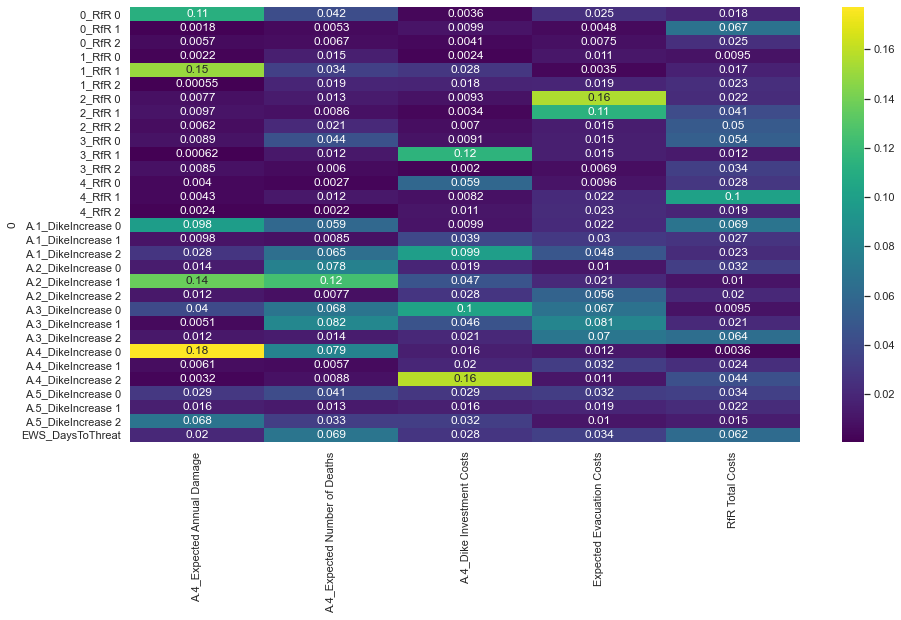

In [7]:
# Plotting feature scores for the levers of the model for the outcomes of interest
fs = feature_scoring.get_feature_scores_all(df_experiments_s1000_p10[lever_columns], df_outcomes_s1000_p10[outcomes_of_interest])

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [8]:
#Showing statistics of outcomes of interest
for outcome in outcomes_of_interest:
    print('Statistics for : ' , outcome, '\n', df_outcomes_s1000_p10[outcome].describe(), '\n')

Statistics for :  A.4_Expected Annual Damage 
 count    1.000000e+04
mean     9.279252e+05
std      4.821538e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.208495e+08
Name: A.4_Expected Annual Damage, dtype: float64 

Statistics for :  A.4_Expected Number of Deaths 
 count    10000.000000
mean         0.000195
std          0.001138
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.020488
Name: A.4_Expected Number of Deaths, dtype: float64 

Statistics for :  A.4_Dike Investment Costs 
 count    1.000000e+04
mean     4.195952e+07
std      9.385170e+06
min      2.511400e+07
25%      3.526125e+07
50%      4.302570e+07
75%      4.943964e+07
max      5.628786e+07
Name: A.4_Dike Investment Costs, dtype: float64 

Statistics for :  Expected Evacuation Costs 
 count    10000.000000
mean      1856.494384
std       5047.661175
min          0.000000
25%          0.000000
50%        124.500

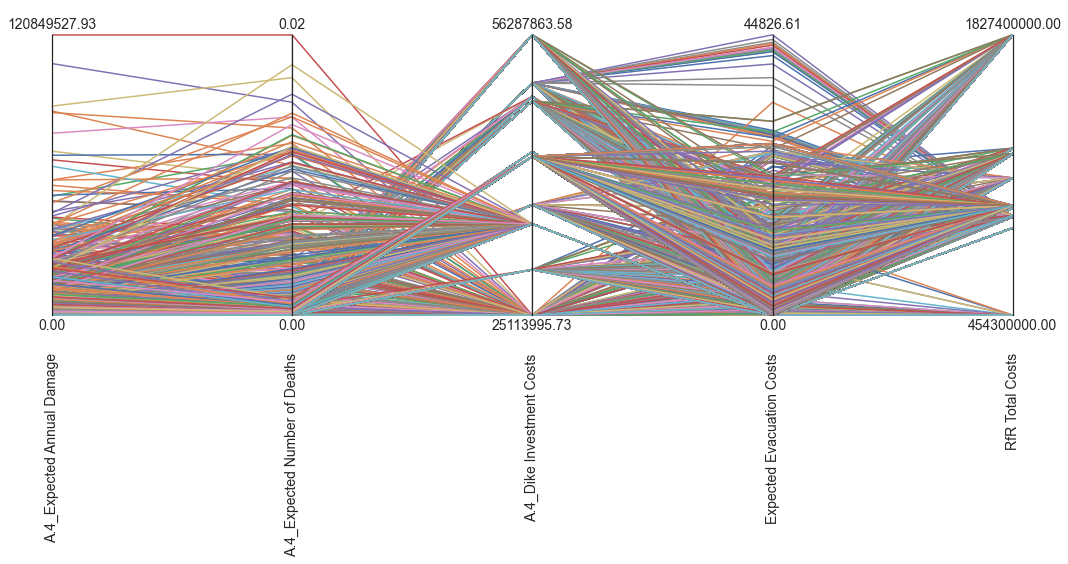

In [9]:
#parallel coordinate plot. In a parallel coordinate plot, the dimensions are visualized side by side.
#Each line represents a scenario that is pareto optimal 

limits = parcoords.get_limits(df_outcomes_s1000_p10[outcomes_of_interest])
axes = parcoords.ParallelAxes(limits)
fig = axes.plot(df_outcomes_s1000_p10[outcomes_of_interest])

plt.savefig('figures/tradeoff.png')
plt.show()


## Prim

In [137]:
# Defining thresholds for outcomes of interest
df_outcomes_s1000_p10['deaths_of_interest'] = df_outcomes_s1000_p10['A.4_Expected Number of Deaths'] > 0.00009
df_outcomes_s1000_p10['damages_of_interest'] = df_outcomes_s1000_p10['A.4_Expected Annual Damage'] > 9.28e+05
df_outcomes_s1000_p10['evacuation_of_interest'] = df_outcomes_s1000_p10['Expected Evacuation Costs'] > 4000
df_outcomes_s1000_p10['all'] = df_outcomes_s1000_p10['deaths_of_interest'] & df_outcomes_s1000_p10['damages_of_interest'] 

coverage    0.973094
density     0.250144
id                10
mass           0.347
mean        0.250144
res_dim            1
Name: 10, dtype: object

             box 10                                           
                min       max                        qp values
A.4_pfail  0.000261  0.346912  [-1.0, 1.8801671071181784e-171]



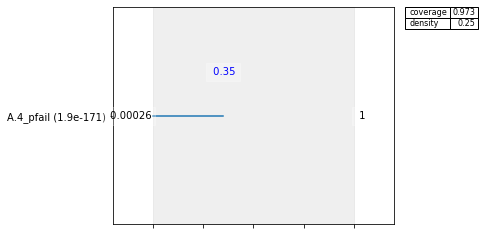

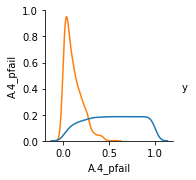

In [24]:
#Calculating prim boxes for the gorssel deaths and damages
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['all'].values, threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

n_box = 10

box1.inspect(n_box) 
box1.inspect(n_box, style="graph")
box1.show_pairs_scatter(n_box)

plt.show()

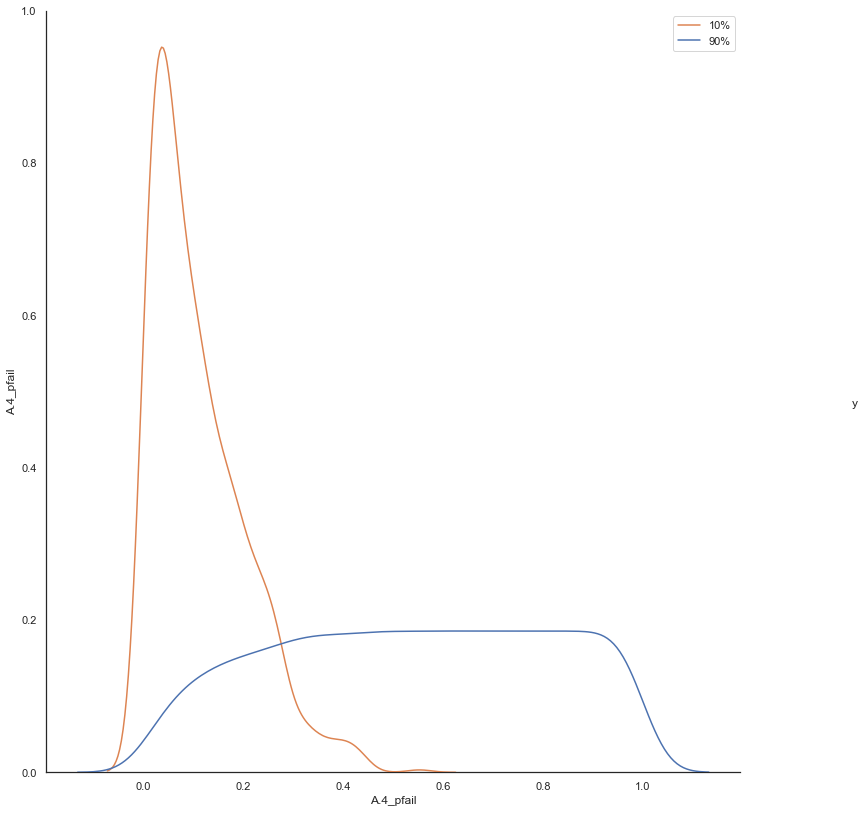

In [70]:
# Plotting the pdf of the samples for gorssels objectives
g = box1.show_pairs_scatter(n)

g.fig.set_size_inches(15,15)
plt.legend(loc='upper right', labels=['10%', '90%'])
plt.savefig('figures/density_prim.png')

In [25]:
#Resampling test
box1.resample(n_box)

,reproduce coverage,reproduce density
A.4_pfail,100.0,100.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.1_pfail,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0
A.2_pfail,0.0,0.0
A.3_Bmax,0.0,0.0
A.3_Brate,0.0,0.0


[MainProcess/INFO] 10000 points remaining, containing 993 cases of interest
[MainProcess/INFO] mean: 0.5981818181818181, mass: 0.055, coverage: 0.33131923464249746, density: 0.5981818181818181 restricted_dimensions: 2


coverage    0.577039
density     0.489744
id                20
mass           0.117
mean        0.489744
res_dim            1
Name: 20, dtype: object

             box 20                                          
                min       max                       qp values
A.4_pfail  0.000261  0.116865  [-1.0, 4.520370409356158e-252]



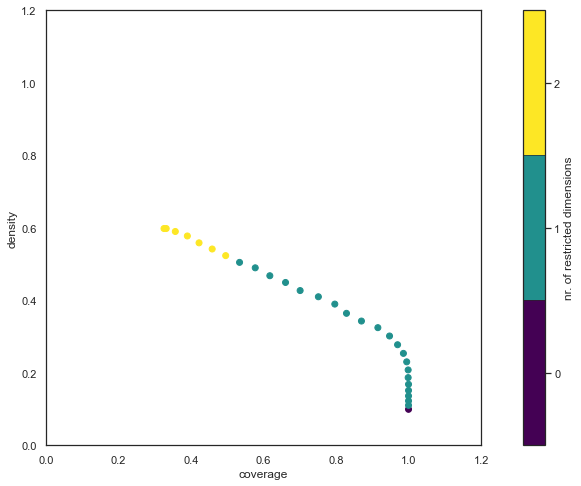

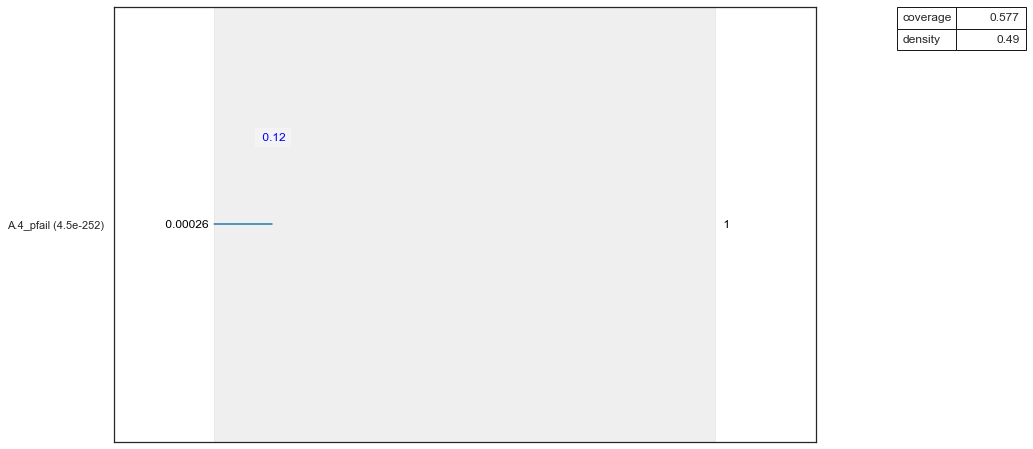

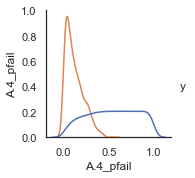

In [11]:
#Calculating prim for damages for gorssel
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['damages_of_interest'], threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

n= 20
box1.show_tradeoff()
box1.inspect(n)
box1.inspect(n, style="graph")
box1.show_pairs_scatter(n)

plt.show()

[MainProcess/INFO] 10000 points remaining, containing 1001 cases of interest
[MainProcess/INFO] mean: 0.5981481481481481, mass: 0.054, coverage: 0.3226773226773227, density: 0.5981481481481481 restricted_dimensions: 2


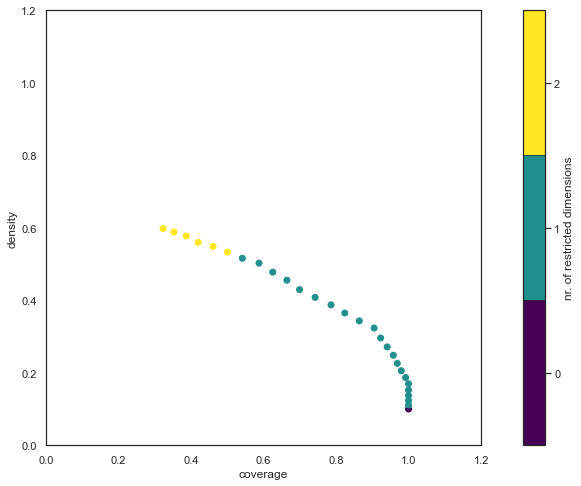

In [12]:
#Calculating prim for deaths of gorssel
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['deaths_of_interest'], threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

n= 20
box1.show_tradeoff()
#box1.inspect(n)
#box1.inspect(n, style="graph")
#box1.show_pairs_scatter(n)

plt.show()

coverage       0.625
density     0.205128
id                11
mass           0.312
mean        0.205128
res_dim            1
Name: 11, dtype: object

             box 11                                          
                min       max                       qp values
A.3_pfail  0.000367  0.311683  [-1.0, 2.0154579861719065e-64]



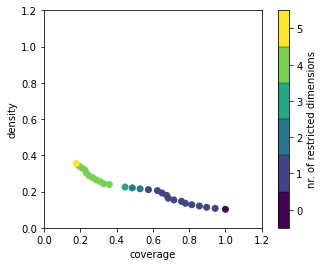

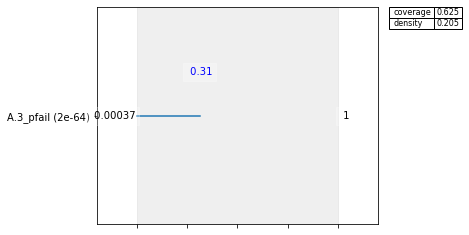

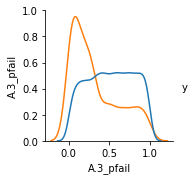

In [146]:
#Calculating prim for evacuation outcome
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['evacuation_of_interest'], threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

n= 11
box1.show_tradeoff()
box1.inspect(n)
box1.inspect(n, style="graph")
box1.show_pairs_scatter(n)

plt.show()

## Dimensional Stacking

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


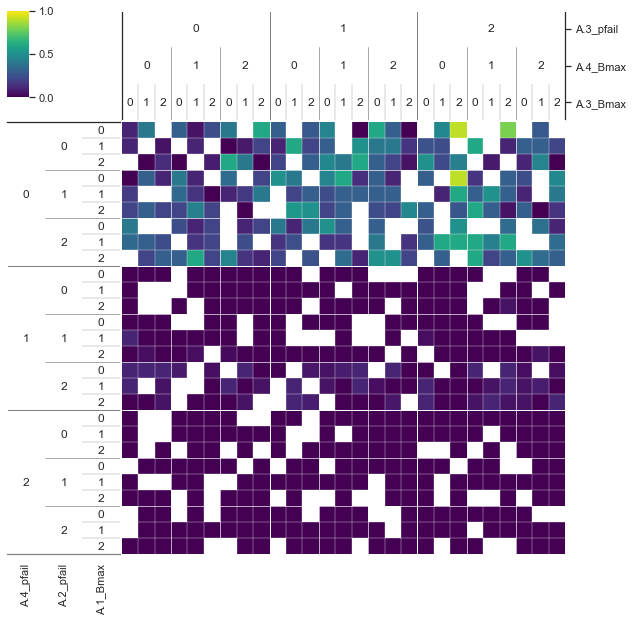

In [28]:
# Calculating dimensional stacking for deaths of interest for gorssel
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['deaths_of_interest'])

plt.savefig('figures/dimensional_stacking_deaths.png', bbox_inches='tight')
plt.show()

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


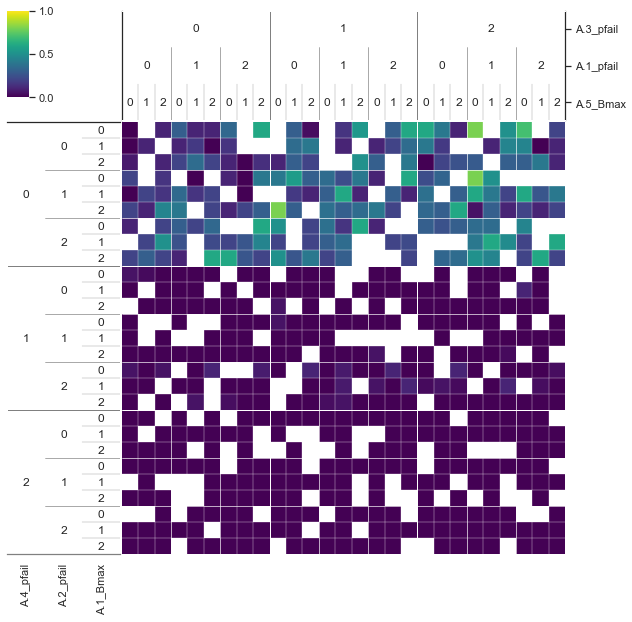

In [29]:
# Calculating dimensional stacking for damages of interest for gorssel
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['damages_of_interest'])

plt.savefig('figures/dimensional_stacking_damages.png', bbox_inches='tight')
plt.show()

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


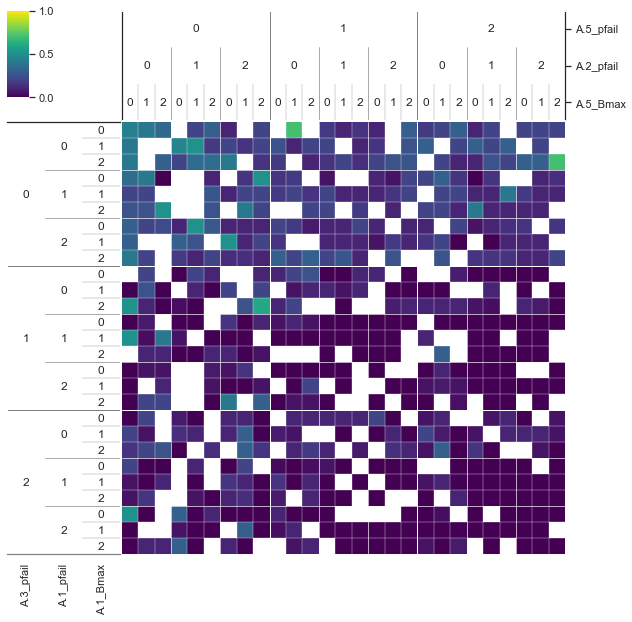

In [30]:
# Calculating dimensional stacking for evacuation of interest
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['evacuation_of_interest'])

plt.savefig('figures/dimensional_stacking_evuaction.png', bbox_inches='tight')
plt.show()

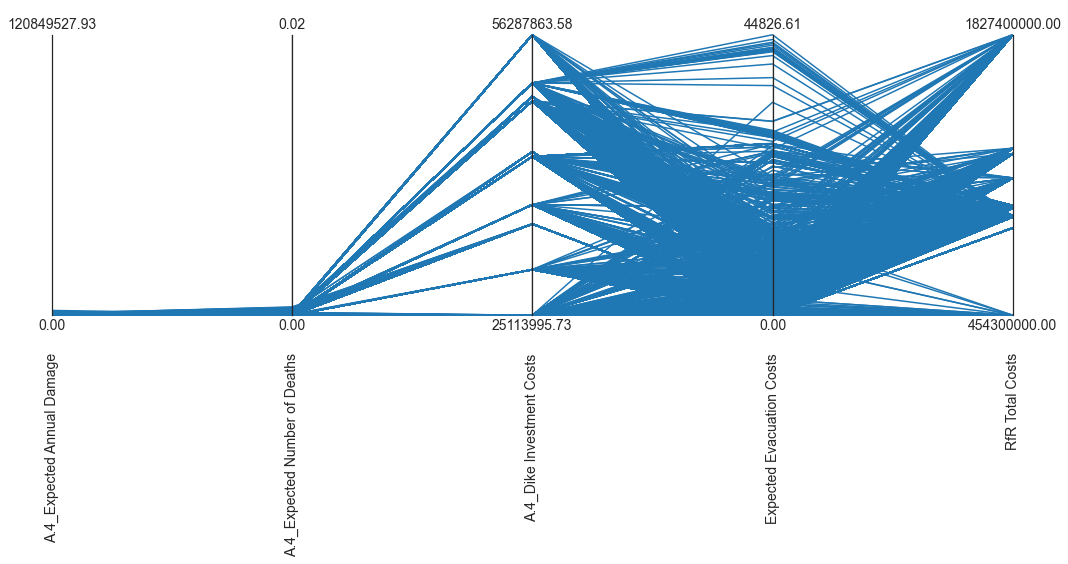

In [36]:
# Plotting the different values of outcomes for different scenarios
limits = parcoords.get_limits(df_outcomes_s1000_p10[outcomes_of_interest])
axes = parcoords.ParallelAxes(limits)
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['all']==0][outcomes_of_interest], color=colors[0])
#axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['deaths_of_interest']==1][outcomes_of_interest], color=colors[7])

plt.savefig('figures/tradeoff.png')
# we can invert an axis if necessary, so the direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()

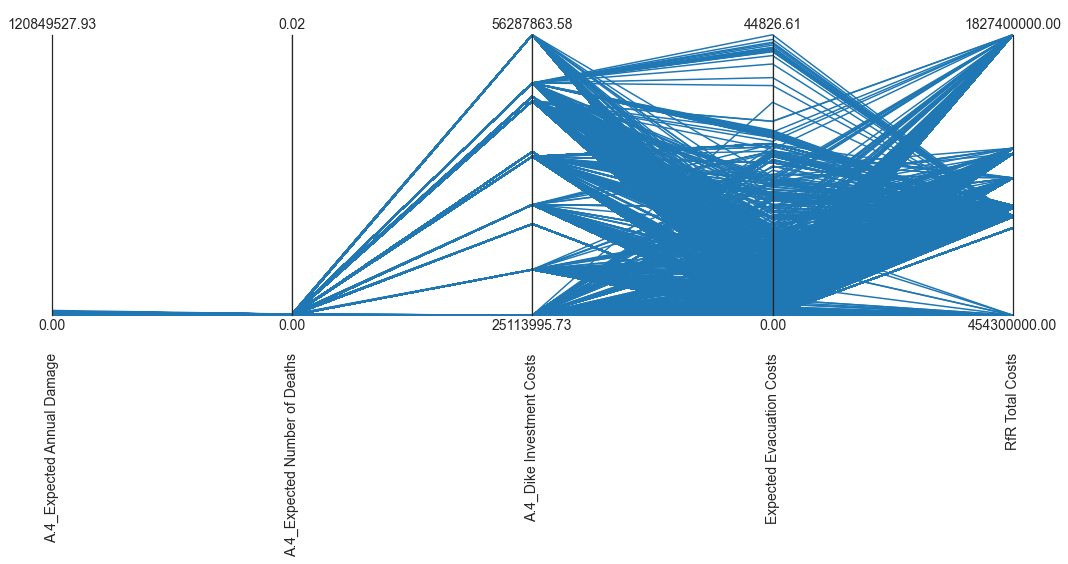

In [26]:
# Plotting the different values of outcomes for different scenarios
limits = parcoords.get_limits(df_outcomes_s1000_p10[outcomes_of_interest])
axes = parcoords.ParallelAxes(limits)
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['deaths_of_interest']==0][outcomes_of_interest], color=colors[0])
#axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['deaths_of_interest']==1][outcomes_of_interest], color=colors[7])

plt.savefig('figures/tradeoff.png')
# we can invert an axis if necessary, so the direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()

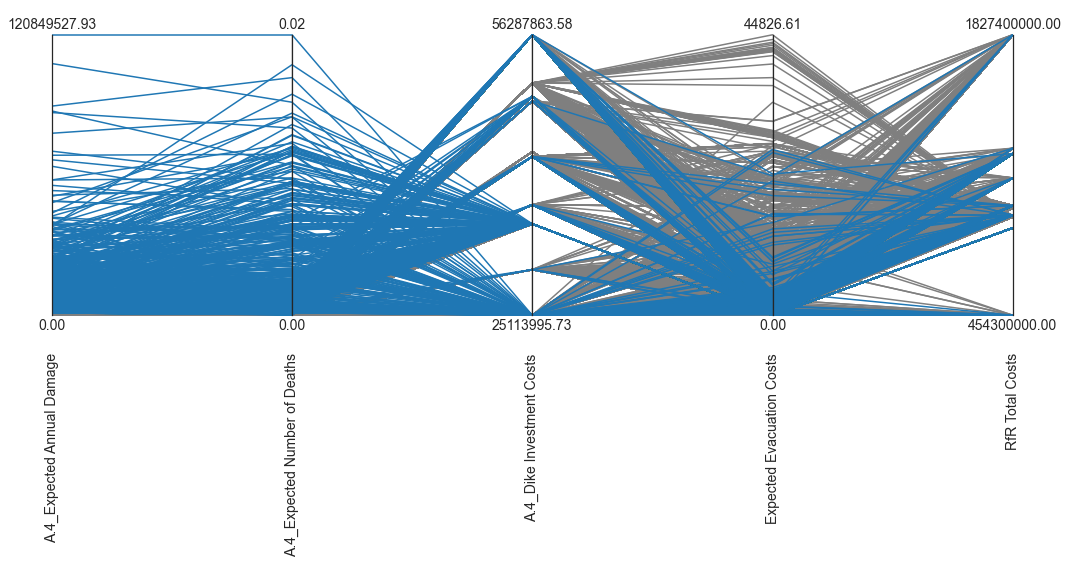

In [23]:
# Plotting the different values of outcomes for different scenarios
limits = parcoords.get_limits(df_outcomes_s1000_p10[outcomes_of_interest])
axes = parcoords.ParallelAxes(limits)
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['damages_of_interest']==0][outcomes_of_interest], color=colors[7])
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['damages_of_interest']==1][outcomes_of_interest], color=colors[0])

plt.savefig('figures/tradeoff.png')
# we can invert an axis if necessary, so the direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()

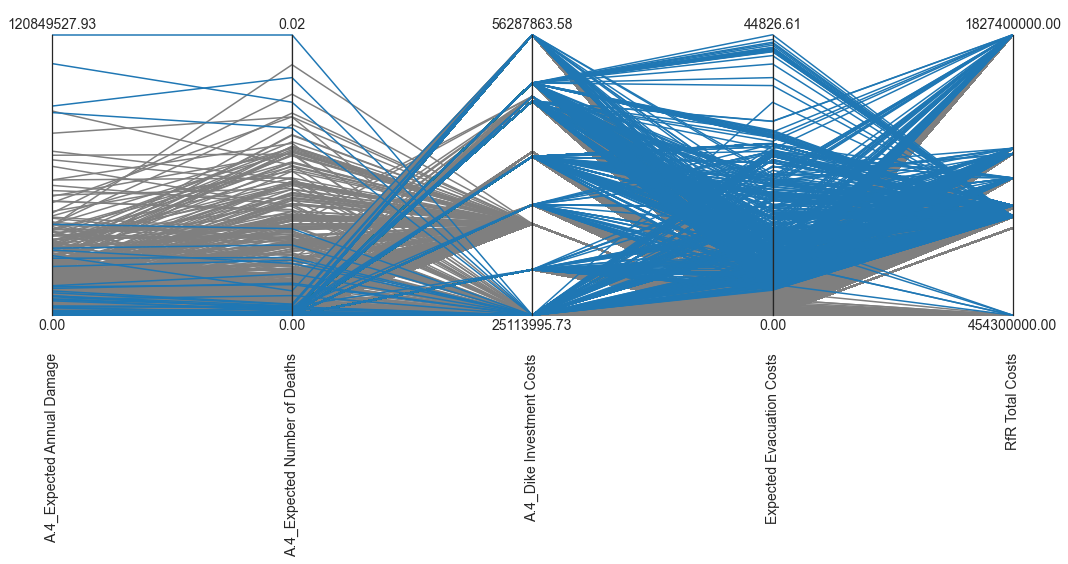

In [24]:
# Plotting the different values of outcomes for different scenarios
limits = parcoords.get_limits(df_outcomes_s1000_p10[outcomes_of_interest])
axes = parcoords.ParallelAxes(limits)
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['evacuation_of_interest']==0][outcomes_of_interest], color=colors[7])
axes.plot(df_outcomes_s1000_p10[df_outcomes_s1000_p10['evacuation_of_interest']==1][outcomes_of_interest], color=colors[0])

plt.savefig('figures/tradeoff.png')
# we can invert an axis if necessary, so the direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()

# Overall aggregated over place

This analysis includes the outcomes of interest for rijkswaterstaat on a higher regional level

## Initial Feature Scoring

In [6]:
# Outcomes of interest for rijkswaterstaat
outcomes_of_interest_overall = ['Total Expected Number of Deaths', 'Total Expected Annual Damage']

In [7]:
#Defining threshold for the outcomes of interest
df_outcomes_s1000_p10['Total Expected Annual Damage'] = df_outcomes_s1000_p10['A.1_Expected Annual Damage'] + df_outcomes_s1000_p10['A.2_Expected Annual Damage'] + df_outcomes_s1000_p10['A.3_Expected Annual Damage'] + df_outcomes_s1000_p10['A.4_Expected Annual Damage'] + df_outcomes_s1000_p10['A.5_Expected Annual Damage']
df_outcomes_s1000_p10['Total Expected Number of Deaths'] = df_outcomes_s1000_p10['A.1_Expected Number of Deaths'] + df_outcomes_s1000_p10['A.2_Expected Number of Deaths'] + df_outcomes_s1000_p10['A.3_Expected Number of Deaths'] + df_outcomes_s1000_p10['A.4_Expected Number of Deaths'] + df_outcomes_s1000_p10['A.5_Expected Number of Deaths']

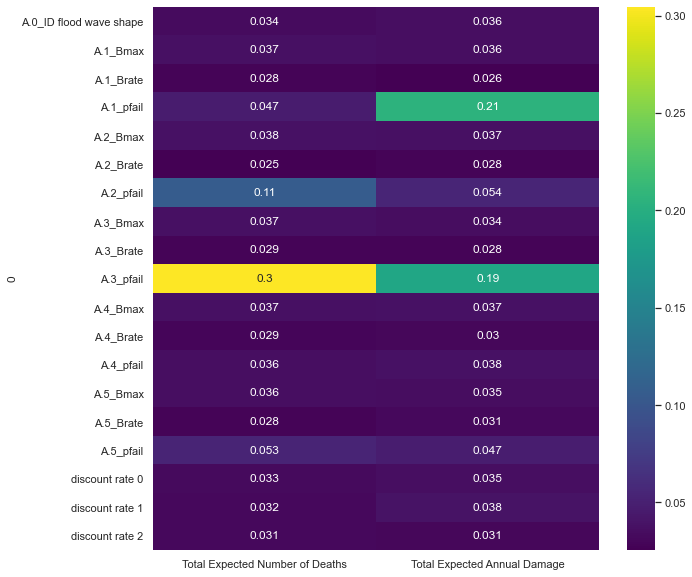

<Figure size 720x720 with 0 Axes>

In [66]:
# Feature scoring for outcomes of interest of Rijkswaterstaat
fs = feature_scoring.get_feature_scores_all(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10[outcomes_of_interest_overall])

sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()
plt.savefig('figures/FeatureScore_s1000_p10')

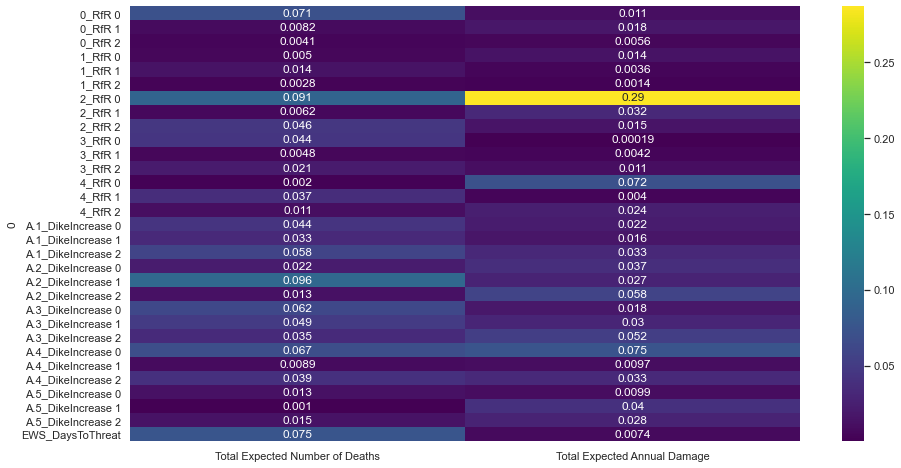

In [8]:
# Feature scoring for levers for outcomes of interest for Rijkswaterstaat
fs = feature_scoring.get_feature_scores_all(df_experiments_s1000_p10[lever_columns], df_outcomes_s1000_p10[outcomes_of_interest_overall])

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [68]:
#Print statistics of all outcomes of interest
for outcome in outcomes_of_interest_overall:
    print('Statistics for : ' , outcome, '\n', df_outcomes_s1000_p10[outcome].describe(), '\n')

Statistics for :  Total Expected Number of Deaths 
 count    10000.000000
mean         0.033271
std          0.095868
min          0.000000
25%          0.000056
50%          0.001771
75%          0.015798
max          0.865613
Name: Total Expected Number of Deaths, dtype: float64 

Statistics for :  Total Expected Annual Damage 
 count    1.000000e+04
mean     8.115009e+07
std      2.363387e+08
min      0.000000e+00
25%      4.788738e+05
50%      9.036987e+06
75%      4.257970e+07
max      2.723428e+09
Name: Total Expected Annual Damage, dtype: float64 



## Prim

In [46]:
#Define threshold for total deaths
df_outcomes_s1000_p10['total_deaths'] = df_outcomes_s1000_p10['Total Expected Number of Deaths'] > 0.02

[MainProcess/INFO] 10000 points remaining, containing 2254 cases of interest
[MainProcess/INFO] mean: 0.37358490566037733, mass: 0.053, coverage: 0.0878438331854481, density: 0.37358490566037733 restricted_dimensions: 11


coverage    0.578083
density     0.273166
id                 7
mass           0.477
mean        0.273166
res_dim            2
Name: 7, dtype: object

              box 7                                         
                min       max                      qp values
A.3_pfail  0.000367  0.729031  [-1.0, 3.845092516798671e-06]
A.2_pfail  0.000750  0.664123  [-1.0, 0.0006038134334954713]



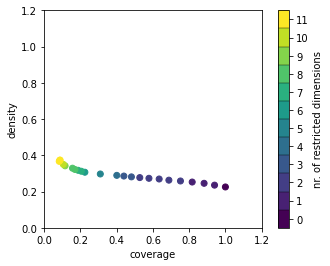

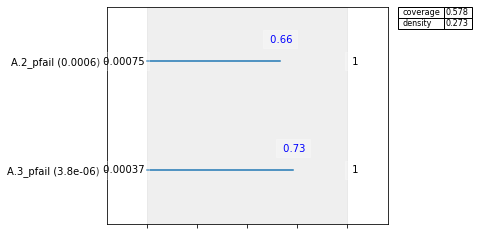

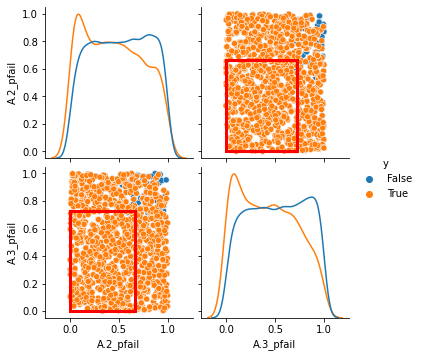

In [82]:
# Calculate prim for total deaths
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['total_deaths'].values, threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
n_box = 7

box1.inspect(n_box) 
box1.inspect(n_box, style="graph")
box1.show_pairs_scatter(n_box)

plt.show()

In [78]:
# Define threshold for total damage
df_outcomes_s1000_p10['total_damage'] = df_outcomes_s1000_p10['Total Expected Annual Damage'] > 10e+07

[MainProcess/INFO] 10000 points remaining, containing 1426 cases of interest
[MainProcess/INFO] mean: 0.3584905660377358, mass: 0.053, coverage: 0.1332398316970547, density: 0.3584905660377358 restricted_dimensions: 8


coverage    0.741935
density     0.179322
id                 5
mass            0.59
mean        0.179322
res_dim            1
Name: 5, dtype: object

              box 5                                          
                min       max                       qp values
A.3_pfail  0.000367  0.590036  [-1.0, 3.2447679664343665e-15]



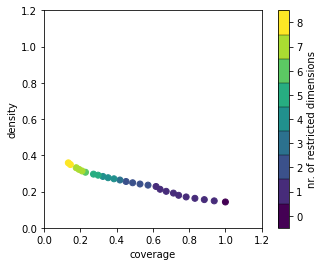

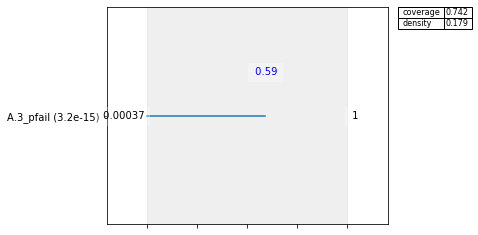

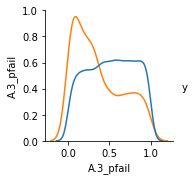

In [80]:
# Calculate prim for total damage
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['total_damage'].values, threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
n_box = 5

box1.inspect(n_box) 
box1.inspect(n_box, style="graph")
box1.show_pairs_scatter(n_box)

plt.show()

In [105]:
# Define column for for theshold of total deaths and total damage
df_outcomes_s1000_p10['both'] = df_outcomes_s1000_p10['total_deaths'] & df_outcomes_s1000_p10['total_damage']

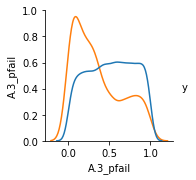

In [134]:
# Show distribution of samples for both scenarios
box1.show_pairs_scatter(n_box)
plt.savefig('figures/prim_regional_pdf.png')

[MainProcess/INFO] 10000 points remaining, containing 1295 cases of interest
[MainProcess/INFO] mean: 0.34074074074074073, mass: 0.054, coverage: 0.14208494208494207, density: 0.34074074074074073 restricted_dimensions: 7


coverage    0.632432
density     0.212176
id                 9
mass           0.386
mean        0.212176
res_dim            1
Name: 9, dtype: object

              box 9                                       
                min      max                     qp values
A.3_pfail  0.000367  0.38616  [-1.0, 5.29380006695952e-46]



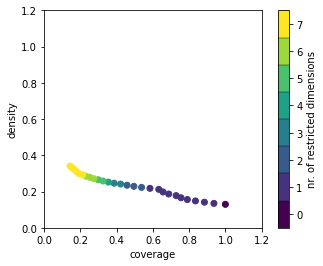

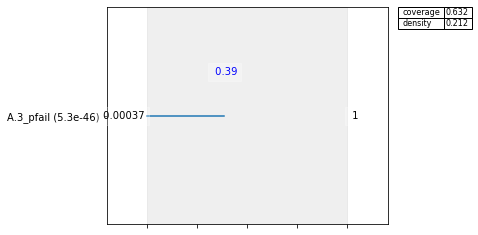

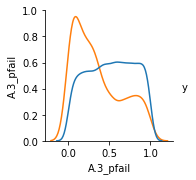

In [108]:
# Calculate prim for both deaths and damages scenario
prim_alg = prim.Prim(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['both'].values, threshold=0.3, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
n_box = 9

box1.inspect(n_box) 
box1.inspect(n_box, style="graph")
box1.show_pairs_scatter(n_box)

plt.show()

In [135]:
#Resampling test
box1.resample(n_box)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
A.3_pfail,100.0,100.0
A.5_pfail,10.0,10.0
A.2_pfail,0.0,10.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.1_pfail,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0
A.3_Bmax,0.0,0.0


## Dimensional Stacking

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


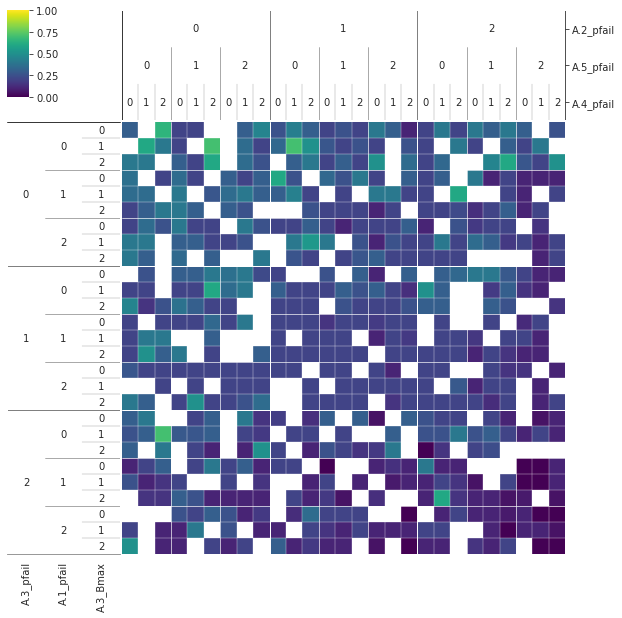

In [87]:
#Dimensional stacking for total deaths
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['total_deaths'])

plt.savefig('figures/dimensional_stacking_deaths_all.png', bbox_inches='tight')
plt.show()

C:\Users\Willemijn Tutuarima\miniconda3\envs\gds\lib\site-packages\ema_workbench\analysis\dimensional_stacking.py:423: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ooi = pd.DataFrame(y[:, np.newaxis], columns=[ooi_label])


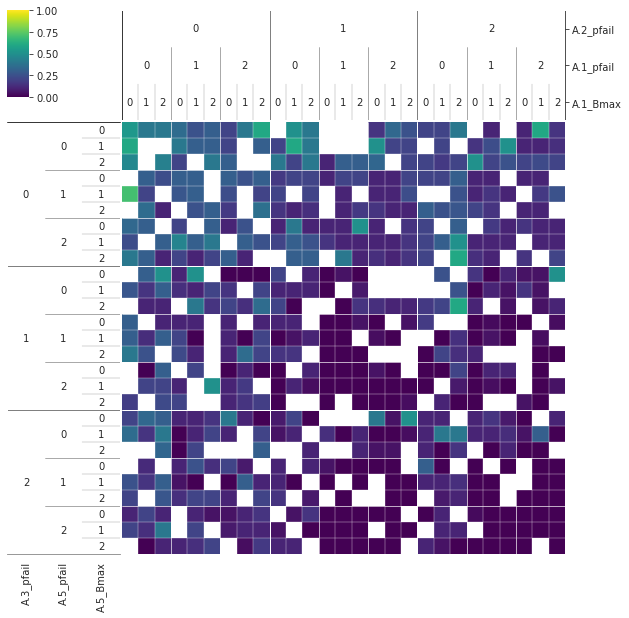

In [88]:
# Dimensional stacking for total damage
dimensional_stacking.create_pivot_plot(df_experiments_s1000_p10[uncertainties_columns], df_outcomes_s1000_p10['total_damage'])

plt.savefig('figures/dimensional_stacking_damages_all.png', bbox_inches='tight')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


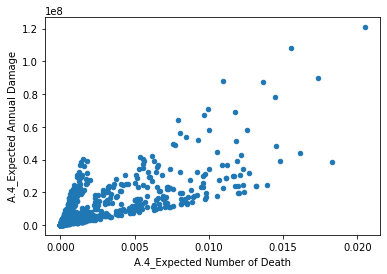

In [104]:
# Scatter plot between gorssels deaths and damages
df_outcomes_s1000_p10.plot.scatter(x='A.4_Expected Number of Deaths', y='A.4_Expected Annual Damage')

plt.xlabel('A.4_Expected Number of Death')
plt.ylabel('A.4_Expected Annual Damage')

plt.savefig('figures/scatter.png')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


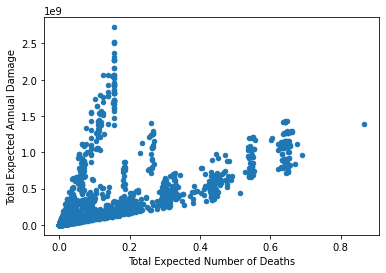

In [131]:
# Scatter plot between total deaths and damages
x = df_outcomes_s1000_p10['Total Expected Number of Deaths']
y = df_outcomes_s1000_p10['Total Expected Annual Damage']
z = df_outcomes_s1000_p10['Expected Evacuation Costs']
df_outcomes_s1000_p10.plot.scatter(x='Total Expected Number of Deaths', y='Total Expected Annual Damage')

plt.xlabel('Total Expected Number of Deaths')
plt.ylabel('Total Expected Annual Damage')

plt.savefig('figures/scatter_regional.png')
plt.show()

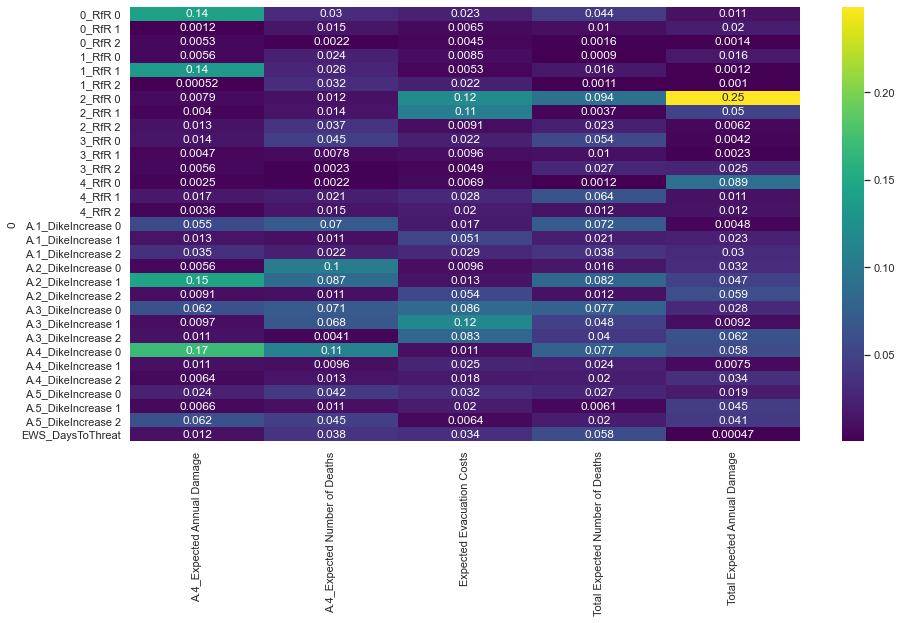

In [10]:
# Feature scores of levers for all outcomes of interest
fs = feature_scoring.get_feature_scores_all(df_experiments_s1000_p10[lever_columns], df_outcomes_s1000_p10[outcomes_of_interest+outcomes_of_interest_overall])

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(fs, cmap="viridis", annot=True)
plt.savefig('figures/lever_feature_score.png', bbox_inches='tight')
plt.show()

In [14]:
# Calculate feature scores of levers 
scores = feature_scoring.get_ex_feature_scores(df_experiments_s1000_p10[lever_columns], df_outcomes_s1000_p10[outcomes_of_interest+outcomes_of_interest_overall],max_features=0.6, mode=RuleInductionType.REGRESSION)[0]
scores

,1
0,
2_RfR 0,0.333292
4_RfR 0,0.178618
A.3_DikeIncrease 2,0.094838
A.4_DikeIncrease 0,0.060153
A.2_DikeIncrease 2,0.052845
A.2_DikeIncrease 1,0.051889
A.4_DikeIncrease 2,0.036709
3_RfR 2,0.028850
A.5_DikeIncrease 1,0.024939
